# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import pandas as pd
from datetime import datetime as DT

In [2]:
# from imod import msw
# from imod import mf6
# import primod

In [3]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM
import WS_Mdl.calcs as C

In [4]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)

<module 'WS_Mdl.utils_imod' from 'C:\\Users\\Karam014\\OneDrive - Universiteit Utrecht\\WS_Mdl\\code\\WS_Mdl\\utils_imod.py'>

In [5]:
# Import sfrmaker and other necessary packages for SFR network creation
import sfrmaker as sfr
import geopandas as gpd
import numpy as np

In [6]:
import fiona

In [7]:
sfr.__version__

'0.11.3'

In [8]:
from WS_Mdl.utils import bold, style_reset

# Options

In [9]:
Pa_GPkg_1ry = r'C:\OD\WS_Mdl\models\NBr\PrP\SFR\BrabantseDelta\WBD_SW_NW_1ry.gpkg' 
Pa_GPkg = r"C:\OD\WS_Mdl\models\NBr\PrP\SFR\BrabantseDelta\acceptatiedatabase.gdb"
detailed = 'hydroobject'
primary = 'LEGGER_VASTGESTELD_WATERLOOP_CATEGORIE_A'

In [10]:
MdlN = 'NBr33'

In [11]:
U.set_verbose(False)

In [12]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax = [float(i) for i in d_INI['WINDOW'].split(',')]
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

# 1ry SW Nw PrP

## Load

In [13]:
GDF_all = gpd.read_file(Pa_GPkg_1ry)

In [14]:
GDF_all

,OBJECTID,CODE,WS_STATUS_L,WS_LEGGERCATEGORIE_L,WS_LEGGERBRON_L,DATUM_VASTGESTELD,LEGGER_KENMERK,WS_ONDERHOUDSPLICHTIGE_L,WS_ONDERHOUDSPLICHT_L,WS_BODEMBREEDTE_L,...,WS_OMSCHRIJVING_TRAJECT_L,WS_LEGGERVERWIJZING_L,WS_HYPERLINK_PRO_OPW_L,WS_HYPERLINK_PRO_VW_L,WS_LEGGERBRON_OMW_L,WS_LEGGERBRON_WAW_L,WS_LEGGERBRON_COS_L,WS_HYPERLINK_BESLUIT_L,SHAPE_Length,geometry
0,1,OVK12326,"Vastgesteld, Besluit geverifieerd, ingemeten",Oppervlaktewaterlichamen,"11UT009138, kernregistratie",2021-03-30 00:00:00+00:00,"Waterschapsblad 2021, 4434",None,None,0.50,...,None,Niet van toepassing,None,None,None,None,None,None,103.786374,"MULTILINESTRING ((82178.821 382139.593, 82180...."
1,2,OVK21780,"Vastgesteld, Besluit geverifieerd, ingemeten",Oppervlaktewaterlichamen,Oude legger de gewijzigde Cruijslandpolders 19...,2021-03-30 00:00:00+00:00,"Waterschapsblad 2021, 4434",None,None,1.50,...,None,Niet van toepassing,None,None,None,None,None,None,159.245366,"MULTILINESTRING ((87960.311 397958.808, 87960...."
2,3,OVK02233,"Vastgesteld, Ligging gewijzigd, tabel ongewijzigd",Oppervlaktewaterlichamen,None,2021-03-30 00:00:00+00:00,"Waterschapsblad 2021, 4434",None,None,0.60,...,None,Niet van toepassing,None,None,None,None,None,None,211.357944,"MULTILINESTRING ((111124.488 396263.763, 11113..."
3,4,OVK07620,"Vastgesteld, Ligging gewijzigd, tabel ongewijzigd",Oppervlaktewaterlichamen,None,2021-03-30 00:00:00+00:00,"Waterschapsblad 2021, 4434",None,None,0.90,...,None,Niet van toepassing,None,None,None,None,None,None,565.948226,"MULTILINESTRING ((104001.385 404319.356, 10400..."
4,5,OVK05547,"Vastgesteld, Besluit geverifieerd, ingemeten",Oppervlaktewaterlichamen,"Oude legger De polders van Nieuw Vosmeer 1971,...",2021-03-30 00:00:00+00:00,"Waterschapsblad 2021, 4434",None,None,1.77,...,None,Niet van toepassing,None,None,None,None,None,None,1415.946440,"MULTILINESTRING ((75046.141 401865.437, 75045...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12859,12860,OVK03414,Vigerende legger,Oppervlaktewaterlichamen,None,2024-11-21 00:00:00+00:00,"Waterschapsblad 2024, 25527",Gemeente Waalwijk,None,0.50,...,None,Niet van toepassing,None,None,14IN032214,None,None,https://zoek.officielebekendmakingen.nl/wsb-20...,230.941879,"MULTILINESTRING ((127154.852 413725.971, 12715..."
12860,12861,OVK08022,Vigerende legger,Oppervlaktewaterlichamen,None,2024-11-21 00:00:00+00:00,"Waterschapsblad 2024, 25527",None,None,0.92,...,None,Niet van toepassing,None,None,448580,None,None,https://zoek.officielebekendmakingen.nl/wsb-20...,562.094599,"MULTILINESTRING ((106839.183 406980.574, 10685..."
12861,12862,OVK21240,Vigerende legger,Oppervlaktewaterlichamen,None,2024-11-21 00:00:00+00:00,"Waterschapsblad 2024, 25527",None,None,1.00,...,None,Niet van toepassing,None,None,757483,None,waterloop was op de legger cat-C tijdens vergu...,https://zoek.officielebekendmakingen.nl/wsb-20...,405.070769,"MULTILINESTRING ((98685.008 394485.756, 98680...."
12862,12863,OVK07617,Vigerende legger,Oppervlaktewaterlichamen,None,2024-11-21 00:00:00+00:00,"Waterschapsblad 2024, 25527",None,None,0.80,...,None,Niet van toepassing,None,None,IP800380 verbetering RWK,None,None,https://zoek.officielebekendmakingen.nl/wsb-20...,512.689618,"MULTILINESTRING ((102983.931 404344.646, 10300..."


## Calculate routing

### Extract coordinates and identify downstream segments.

#### Create Xend and Yend columns

In [15]:
from shapely.geometry import MultiLineString

In [16]:
GDF_all['Xstart'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[0][0]) # Access X coorddinate of first point in first linestring
GDF_all['Ystart'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[0][1])
GDF_all['Xend'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[-1][0])
GDF_all['Yend'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[-1][1])

In [17]:
print("✓ Start and end coordinates extracted.")
l_coord_cols = ['CODE', 'Xstart', 'Ystart', 'Xend', 'Yend']
GDF_all[l_coord_cols].head()

✓ Start and end coordinates extracted.


,CODE,Xstart,Ystart,Xend,Yend
0,OVK12326,82178.8210,382139.5930,82211.0763,382230.8210
1,OVK21780,87960.3111,397958.8084,87987.8930,397803.1720
2,OVK02233,111124.4879,396263.7630,111286.6935,396369.1693
3,OVK07620,104001.3850,404319.3560,104532.9200,404493.5701
4,OVK05547,75046.1407,401865.4367,73901.1920,401618.4030


#### Limit X, Y to model area

In [18]:
GDF = GDF_all[  ( (GDF_all['Xstart'].between(Xmin, Xmax, inclusive='both') | GDF_all['Xend'].between(Xmin, Xmax, inclusive='both') ) &
              (GDF_all['Ystart'].between(Ymin, Ymax, inclusive='both') | GDF_all['Yend'].between(Ymin, Ymax, inclusive='both') ) ) ]

In [19]:
# Create a lookup dictionary from start coordinates to CODE
coord_to_id = {(row.Xstart, row.Ystart): (row.CODE, row.OBJECTID) for row in GDF.itertuples()}

print(f"✓ Lookup dictionary created with {bold}{len(coord_to_id)}{style_reset} entries.")

✓ Lookup dictionary created with 583 entries.


The number of features selected in QGIS (within model area) is 562, which suprisingly is bigger than 556. We'll continue without investigating further for now.

#### Identify downstream

In [20]:
# Function to find the downstream ID
def get_DStr(row):
    end_coords = (row.Xend, row.Yend)
    result = coord_to_id.get(end_coords, (0, 0))
    return result

# Apply the function to create the 'DStr' column
GDF[['DStr_code', 'DStr_ID']] = GDF.apply(get_DStr, axis=1, result_type='expand')

print("✓ 'DStr' columns calculated.")

✓ 'DStr' columns calculated.


In [21]:
print(f'{round(GDF['DStr_code'].value_counts().max()/GDF.shape[0]*100, 2)} % of DStrs are 0 (i.e. no start coordinates match the end coordinates of the current node).')

9.48 % of DStrs are 0 (i.e. no start coordinates match the end coordinates of the current node).


The percentage is bigger than expected. Let's investigate.

### Investigate segments that failed to connect

#### Check out number of matches/no matches

In [22]:
GDF['DStr_match'] = GDF['DStr_code'].isin(GDF['CODE'])
GDF['DStr_code'].value_counts()

DStr_code
0           56
OVK03070     3
OVK11688     3
OVK02834     2
OVK01661     2
            ..
OVK02106     1
OVK02327     1
OVK01633     1
OVK01349     1
OVK01433     1
Name: count, Length: 451, dtype: int64

It makes sense that most nodes have just a few upstream nodes. 56 nodes are not connected.

In [23]:
GDF['DStr_match'].value_counts()

DStr_match
True     535
False     56
Name: count, dtype: int64

#### Calculate min distance from start to any reach's end and investigate no matches.

In [24]:
GDF['min_Dist'] = 0.0
GDF.loc[GDF['DStr_code'] == 0, 'min_Dist'] = GDF.loc[GDF['DStr_code'] == 0].apply(lambda row: C.c_Dist(row['Xend'], row['Yend'], GDF['Xstart'], GDF['Ystart']).min(), axis=1)

In [25]:
N_total_no_match = (GDF['DStr_code'] == 0).sum()

In [26]:
GDF.loc[GDF['DStr_match']==False,'min_Dist'].describe()

count     56.000000
mean      50.930158
std      119.328808
min        0.000100
25%        0.000100
50%        0.000241
75%       10.010838
max      564.173123
Name: min_Dist, dtype: float64

In [27]:
l_Vals = [0.001, 0.1, 1, 10, 100, 1000, 10000]

print(f'Out of the {N_total_no_match} segments that do not match:')

N_below_Prv, Val_Prv = 0, 0
for v in l_Vals:
    N_below = (GDF.loc[GDF['DStr_match']==False,'min_Dist'] <= v).sum()
    P_below = round(N_below / N_total_no_match * 100, 2)
    
    sample_gdf = GDF.loc[(GDF['min_Dist'] > Val_Prv) & (GDF['min_Dist'] <= v), ['CODE', 'min_Dist']].sort_values(by='min_Dist')
    sample_gdf['Code:min_Dist'] = sample_gdf.apply(lambda row: f"{row['CODE']}: {row['min_Dist']:8.4f}", axis=1)
    sample_gdf = sample_gdf['Code:min_Dist']
    example_nodes = sample_gdf.iloc[:].tolist()

    print(f'-{Val_Prv:6} < min_Dist <= {v:5} |N: {N_below:6} (+ {(N_below - N_below_Prv):4}) ({round(P_below,1):5} %) | Codes: {example_nodes}\n')

    N_below_Prv, Val_Prv = N_below, v

Out of the 56 segments that do not match:
-     0 < min_Dist <= 0.001 |N:     37 (+   37) ( 66.1 %) | Codes: ['OVK02919:   0.0001', 'OVK02936:   0.0001', 'OVK02055:   0.0001', 'OVK02089:   0.0001', 'OVK01666:   0.0001', 'OVK20480:   0.0001', 'OVK20466:   0.0001', 'OVK02235:   0.0001', 'OVK00961:   0.0001', 'OVK20990:   0.0001', 'OVK01440:   0.0001', 'OVK00937:   0.0001', 'OVK01445:   0.0001', 'OVK00976:   0.0001', 'OVK01793:   0.0001', 'OVK01694:   0.0001', 'OVK02909:   0.0001', 'OVK00907:   0.0001', 'OVK01716:   0.0001', 'OVK01492:   0.0001', 'OVK02214:   0.0001', 'OVK00960:   0.0001', 'OVK00965:   0.0001', 'OVK01537:   0.0001', 'OVK02101:   0.0001', 'OVK01675:   0.0001', 'OVK02326:   0.0001', 'OVK01803:   0.0002', 'OVK20449:   0.0003', 'OVK02098:   0.0003', 'OVK22007:   0.0003', 'OVK01674:   0.0004', 'OVK00975:   0.0005', 'OVK01717:   0.0006', 'OVK11693:   0.0006', 'OVK00974:   0.0006', 'OVK11686:   0.0010']

- 0.001 < min_Dist <=   0.1 |N:     41 (+    4) ( 73.2 %) | Codes: ['OVK021

The total number of segments that do not match is too high to check them all, but we'll check some cases. Check C:\OD\WS_Mdl\Mng\Mdl_Ipvs.xlsx/WBD_SHP_Eval for more info.

The ones <1m can be attributed to closing errors, and we can connect them to the closest one via an algorithm.<br>Let's print out the names of the bigger differences, so that we can check them in QGIS.

In [28]:
GDF.loc[GDF['min_Dist'].between(10,100, inclusive='right'), ['CODE', 'min_Dist']].sort_values(by='min_Dist').reset_index(drop=True)

,CODE,min_Dist
0,OVK11551,38.279426
1,OVK02333,56.202931
2,OVK02160,70.170908
3,OVK02830,70.170908
4,OVK01792,84.207934


- **OVK11551**: -- TO BE CORRECTED -- is an anomaly, as it attaches to a very long feature, far from the final start and end.
- **OVK02333**: -- IGNORE -- ends outside the model, so there is no feature to connect to.
- **OVK02830** & **OVK02160**: -- IGNORE -- are in the same spot. one of them is straight, the other one circles around, and they both end outside the model.
- **OVK01792**: -- IGNORE -- also ends outside the model.

In [29]:
GDF.loc[GDF['min_Dist'].between(100,1000, inclusive='right'), ['CODE', 'min_Dist']].sort_values(by='min_Dist').reset_index(drop=True)

,CODE,min_Dist
0,OVK02242,103.059615
1,OVK02238,133.948685
2,OVK02121,158.327719
3,OVK01807,192.357958
4,OVK03078,227.105468
5,OVK02887,360.424861
6,OVK02933,364.087586
7,OVK01682,428.826538
8,OVK00416,564.173123


- **OVK02242**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02238**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02121**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK01807**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK03078**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02887**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek (final Mark outled outside MdlAa) 
- **OVK02933**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK01682**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK00416**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 


### Edit connections

In [30]:
# Initialize the 'multiple_close' column with empty strings
GDF['multiple_close'] = ""

# Select rows to correct
rows_to_correct = GDF[(GDF['DStr_code'] == 0) & (GDF['min_Dist'] < 1)].copy()

print(f"Found {len(rows_to_correct)} segments with no downstream connection and a potential connection within 1m.")

# Create a Series of all start coordinates for faster access
all_starts_x = GDF['Xstart']
all_starts_y = GDF['Ystart']
all_codes = GDF['CODE']
all_object_ids = GDF['OBJECTID']

corrected_count = 0
multiple_count = 0

# Loop through the rows that need correction
for index, row in rows_to_correct.iterrows():
    # Calculate distances from the current row's end point to all other rows' start points
    distances = C.c_Dist(row['Xend'], row['Yend'], all_starts_x, all_starts_y)
    
    # Find segments where the distance is less than 1m
    close_mask = (distances < 1) & (GDF.index != index) # Exclude self
    close_segments_codes = all_codes[close_mask].tolist()
    close_segments_object_ids = all_object_ids[close_mask].tolist()
    
    if len(close_segments_codes) == 1:
        # If there is exactly one close segment, update both 'DStr_code' and 'DStr_ID'
        GDF.loc[index, 'DStr_code'] = close_segments_codes[0]
        GDF.loc[index, 'DStr_ID'] = close_segments_object_ids[0]
        corrected_count += 1
    elif len(close_segments_codes) > 1:
        # If there are multiple close segments, store as comma-separated string
        GDF.loc[index, 'multiple_close'] = ", ".join(close_segments_codes)
        multiple_count += 1

print(f"✓ Corrected {corrected_count} segments by updating 'DStr_code' and 'DStr_ID'.")
print(f"✓ Found {multiple_count} segments with multiple potential connections (stored in 'multiple_close').")

Found 42 segments with no downstream connection and a potential connection within 1m.
✓ Corrected 41 segments by updating 'DStr_code' and 'DStr_ID'.
✓ Found 1 segments with multiple potential connections (stored in 'multiple_close').
✓ Corrected 41 segments by updating 'DStr_code' and 'DStr_ID'.
✓ Found 1 segments with multiple potential connections (stored in 'multiple_close').


In [31]:
GDF.loc[GDF['multiple_close']!='', ['CODE', 'multiple_close']].sort_values(by='multiple_close', ascending=False)

,CODE,multiple_close
3533,OVK00976,"OVK00977, OVK01474"


This is an upstremost segment that's really small, so it doesn't matter much where it connects to. We'll connect it to one of the two downstream segments at random.

In [32]:
GDF.loc[GDF['CODE']=='OVK00976', ['DStr_code', 'DStr_ID']] = ['OVK00977', GDF.loc[GDF['CODE']=='OVK00977', 'OBJECTID'].values[0]]

Let's also fix OVK11551, which connects to that very long segment (OVK03013), far from either end.

In [33]:
GDF.loc[GDF['CODE']=='OVK11551', ['DStr_code', 'DStr_ID']] = ['OVK03013', GDF.loc[GDF['CODE']=='OVK03013', 'OBJECTID'].values[0]]

## Explore GDF to Fill SFRmaker Input data requirements

Below, we'll match the shapefile attributes to the SFRmaker requirements as per SFRmaker manual ( https://doi-usgs.github.io/sfrmaker/latest/inputs.html):

**Custom hydrography** <br>
Any Polyline shapefile can be supplied in lieu of NHDPlus, but it must have the following columns, as shown in the second example:
1. **flowlines_file**: path to shapefile
2. **id_column**: unique identifier for each polyline
3. **routing_column**: downstream connection (ID), 0 if none
4. **width1_column**: channel width at start of line, in attr\_length\_units (optional)
5. **width2_column**: channel width at end of line, in attr_length_units (optional)
6. **up_elevation_column**: streambed elevation at start of line, in attr_height_units
7. **dn_elevation_column**: streambed elevation at end of line, in attr_height_units
8. **name_column**: stream name (optional)
9. **attr_length_units**: channel width units
10. **attr_height_units**: streambed elevation units

Here are the columns of the GDF, so we can match them to the SFRmaker requirements:

In [34]:
for i, col in enumerate(GDF.columns):
    print(f"{i}: {col}")

0: OBJECTID
1: CODE
2: WS_STATUS_L
3: WS_LEGGERCATEGORIE_L
4: WS_LEGGERBRON_L
5: DATUM_VASTGESTELD
6: LEGGER_KENMERK
7: WS_ONDERHOUDSPLICHTIGE_L
8: WS_ONDERHOUDSPLICHT_L
9: WS_BODEMBREEDTE_L
10: WS_BH_BOVENSTROOMS_L
11: WS_BH_BENEDENSTROOMS_L
12: WS_BODBREE_ACCPROF_LI_L
13: WS_BODBREE_ACCPROF_RE_L
14: WS_HGT_INSTEEK_LI_L
15: WS_HGT_INSTEEK_RE_L
16: WS_BHGT_ACCPROF_LI_L
17: WS_BHGT_ACCPROF_RE_L
18: WS_TALUD_LINKS_L
19: WS_TALUD_RECHTS_L
20: WS_TALUD_ACCPROF_LI_L
21: WS_TALUD_ACCPROF_RE_L
22: WS_ONDERWATERTALUD_LI_L
23: WS_ONDERWATERTALUD_RE_L
24: WS_HGT_BESCHOEIING_LI_L
25: WS_HGT_BESCHOEIING_RE_L
26: WS_HGT_ONDERK_BES_LI_L
27: WS_HGT_ONDERK_BES_RE_L
28: WS_HGT_INSTEEK_ACCPROF_LI_L
29: WS_HGT_INSTEEK_ACCPROF_RE_L
30: WS_BIJZ_FUNCTIE_L
31: WS_INHOUD_RETENTIE_L
32: WS_LENGTE_L
33: WS_OPW_BIJZ_PROF_L
34: WS_VW_BODEMBREEDTE_L
35: WS_VW_BH_BOVENSTROOMS_L
36: WS_VW_BH_BENEDENSTROOMS_L
37: WS_VW_TALUD_LINKS_L
38: WS_VW_TALUD_RECHTS_L
39: WS_VW_BIJZ_PROF_L
40: WIJZIGING
41: SE_ANNO_CAD_DATA
42:

#### 1. flowlines_file will definitely be Pa_GPkg_1ry 

#### 2. & 3. will most likely be 'OBJECTID' & 'DStr_ID'.
But let's ensure there are no nulls and use the .describe() method to check more details

In [35]:
GDF[['OBJECTID', 'DStr_ID']].isna().sum()

OBJECTID    0
DStr_ID     0
dtype: int64

In [36]:
GDF[['CODE', 'OBJECTID', 'DStr_code', 'DStr_ID']].describe(include='all')

,CODE,OBJECTID,DStr_code,DStr_ID
count,591,591.000000,591.0,591.00000
unique,591,NaN,487.0,NaN
top,OVK01308,NaN,0.0,NaN
freq,1,NaN,13.0,NaN
mean,NaN,6246.402707,NaN,6174.41286
std,NaN,3976.475789,NaN,4026.85889
min,NaN,15.000000,NaN,0.00000
25%,NaN,2359.500000,NaN,2213.00000
50%,NaN,7167.000000,NaN,7082.00000
75%,NaN,8832.000000,NaN,8856.00000


In [37]:
GDF.loc[GDF['DStr_ID']==0, 'DStr_ID'].count()

np.int64(13)

Great. No nuls and 13 DStr_codes with no downstream connection ('DStr'==0) (9 with min_Dist between 100 and 1000, + 5 with min_Dist betwen 10 and 100, -1, that we connected to the meandering long segment).

#### 4. & 5. Widths (at start and end)

There are 4 candidates for those fields:
- 'WS_BODEMBREEDTE_L' (channel bed width)
- 'WS_BODBREE_ACCPROF_LI_L' (Accepted profile bottom width (left) (m))
- 'WS_BODBREE_ACCPROF_RE_L' (Accepted profile bottom width (right) (m))
- 'WS_VW_BODEMBREEDTE_L' (Prescribed bottom width (voorwaarde) (m))

Let's compare the values. We can probably just use WS_BODEMBREEDTE. I think it has no/fewer nuls and the values are similar to the other 3 fields. Then we can upgrade. But let's have a look.

In [38]:
GDF[['CODE', 'OBJECTID', 'WS_BODEMBREEDTE_L', 'WS_BODBREE_ACCPROF_LI_L', 'WS_BODBREE_ACCPROF_RE_L', 'WS_VW_BODEMBREEDTE_L']].describe(include='all')

,CODE,OBJECTID,WS_BODEMBREEDTE_L,WS_BODBREE_ACCPROF_LI_L,WS_BODBREE_ACCPROF_RE_L,WS_VW_BODEMBREEDTE_L
count,591,591.000000,591.000000,15.000000,9.000000,0.0
unique,591,NaN,NaN,NaN,NaN,NaN
top,OVK01308,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,6246.402707,3.257783,7.730000,11.666667,NaN
std,NaN,3976.475789,41.111277,8.591478,9.454232,NaN
min,NaN,15.000000,0.400000,3.200000,3.500000,NaN
25%,NaN,2359.500000,0.700000,3.500000,4.900000,NaN
50%,NaN,7167.000000,0.850000,3.750000,6.200000,NaN
75%,NaN,8832.000000,1.275000,5.750000,20.000000,NaN


In [39]:
GDF.loc[ GDF['WS_BODBREE_ACCPROF_LI_L'].notna() | GDF['WS_BODBREE_ACCPROF_RE_L'].notna() | GDF['WS_VW_BODEMBREEDTE_L'].notna(),
         ['CODE', 'WS_BODEMBREEDTE_L', 'WS_BODBREE_ACCPROF_LI_L', 'WS_BODBREE_ACCPROF_RE_L', 'WS_VW_BODEMBREEDTE_L']]

,CODE,WS_BODEMBREEDTE_L,WS_BODBREE_ACCPROF_LI_L,WS_BODBREE_ACCPROF_RE_L,WS_VW_BODEMBREEDTE_L
369,OVK20487,1.0,6.50,NaN,NaN
511,OVK01430,0.8,NaN,4.4,NaN
775,OVK01438,0.8,3.50,NaN,NaN
2198,OVK00979,0.8,3.20,NaN,NaN
2395,OVK01793,0.5,NaN,20.0,NaN
3106,OVK20485,1.0,5.00,NaN,NaN
3815,OVK01792,0.5,NaN,20.0,NaN
3928,OVK20488,1.0,3.75,NaN,NaN
4588,OVK01547,1.0,30.00,30.0,NaN
5197,OVK20473,0.9,3.50,NaN,NaN


'WS_BODBREE_ACCPROF_LI_L' & 'WS_BODBREE_ACCPROF_RE_L' are not the bottom of the channel. This is clear if we masure the channel width in QGIS. So we won't use those.<br>
'WS_VW_BODEMBREEDTE_L' only has nulls, so we won't use that either.<br>
**So we'll just use 'WS_BODEMBREEDTE_L'.**

#### 6. & 7. Upstream and downstream elevations

In [40]:
GDF[[ 'CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']].describe(include='all')

,CODE,WS_BH_BOVENSTROOMS_L,WS_BH_BENEDENSTROOMS_L
count,591,591.000000,591.000000
unique,591,NaN,NaN
top,OVK01308,NaN,NaN
freq,1,NaN,NaN
mean,NaN,8.995431,8.588037
std,NaN,4.708964,4.636708
min,NaN,-1.630000,-1.650000
25%,NaN,5.860000,5.345000
50%,NaN,9.120000,8.760000
75%,NaN,12.490000,12.015000


No nulls + the percentiles make sense.🟢<br>
Let's make sure the UStr is always higher than the DnStr.<br>
Then let's print out some values to check in QGIS.

In [41]:
(GDF['WS_BH_BOVENSTROOMS_L'] <= GDF['WS_BH_BENEDENSTROOMS_L']).sum(), (GDF['WS_BH_BOVENSTROOMS_L'] < GDF['WS_BH_BENEDENSTROOMS_L']).sum(), (GDF['WS_BH_BOVENSTROOMS_L'] > GDF['WS_BH_BENEDENSTROOMS_L']).sum(), GDF.shape[0]

(np.int64(98), np.int64(24), np.int64(493), 591)

For 98 segments (out of 591), the UStr Elv is <= the DStr Elv. This is not good. We'll have to fix this. 🔴<br>
Only 24/99 have DStr < UStr , the rest are equal. = will be corrected by SFR itself (as far as I know), so no action is required for those.

Let's print out some CODEs where =, to check in QGIS. *(We don't really need to, I'm just curious)*

In [43]:
GDF_Elv = GDF[['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L', 'DStr_code', 'DStr_ID']].copy()

In [44]:
GDF_Elv['Diff'] = GDF_Elv['WS_BH_BOVENSTROOMS_L'] - GDF_Elv['WS_BH_BENEDENSTROOMS_L']

In [45]:
GDF_Elv.loc[GDF_Elv['Diff'] == 0].head()

,CODE,WS_BH_BOVENSTROOMS_L,WS_BH_BENEDENSTROOMS_L,DStr_code,DStr_ID,Diff
318,OVK02978,2.90,2.90,OVK02979,6696,0.0
383,OVK02056,10.35,10.35,OVK02055,481,0.0
397,OVK03014,5.35,5.35,OVK03010,475,0.0
476,OVK00950,10.86,10.86,OVK01471,371,0.0
489,OVK00994,12.30,12.30,OVK00995,7231,0.0


In [46]:
GDF_Elv.loc[ GDF_Elv['Diff'] < 0 ].sort_values(by='CODE', ascending=True).head()

,CODE,WS_BH_BOVENSTROOMS_L,WS_BH_BENEDENSTROOMS_L,DStr_code,DStr_ID,Diff
9584,OVK00476,6.940000,6.950000,OVK02111,7883,-0.01
925,OVK00910,15.230000,15.270000,OVK00909,256,-0.04
4117,OVK00972,14.300000,14.550000,OVK00970,934,-0.25
378,OVK00977,16.299999,16.549999,OVK00969,8850,-0.25
4845,OVK00980,10.070000,10.240000,OVK20501,6949,-0.17


Let's see if any of the problematic segments have multiple UStr segments. That would make a solution harder to implement.<br>
*(if there is only 1 UStr segment, the DStr Elv of the UStr segment can be modified to allow the UStr Elv of the current segmet to be increased as well, but if there are multiple, this becomes more complicated)*

In [49]:
l_problematic = GDF_Elv.loc[ GDF_Elv['Diff'] < 0, 'CODE'].tolist()
for S in l_problematic:
    sum = (GDF['DStr_code']==S).sum()
    if sum > 1:
        print(S, sum)

OVK02982 2
OVK21050 2
OVK03070 3
OVK02326 2
OVK01434 2


There are multiple segments with more than 1 UStr segment. We'll have to consider this when designing the elevation correction logic. 

We'll design an algorithm to fix the ones with <. The ones with = will be fixed by SFR itself (hopefully). The following abbreviations are useful for explaining the concept:
- A: DStr Elv of DStr segment
- B: UStr Elv of DStr segment
- C: DStr Elv of current segment
- D: UStr Elv of current segment
- F: DStr Elv of UStr segment(s)

Here is the idea behind the algorithm:
1. If **C > D & B <= D** :<br>
-> Set **C = D**
2. If **C > D & B > D** :<br>
-> Set **C = D**. Set **B = D**
3. If **C <= D** :<br>
-> **No action**.

Repeat till there are no segments with C < D.

When there is no downstream segment, we apply the logic used in case 1.

In [ ]:
GDF_Elv[['C', 'D']] = GDF_Elv[['WS_BH_BENEDENSTROOMS_L', 'WS_BH_BOVENSTROOMS_L']].copy()

In [ ]:
GDF_Elv = GDF_Elv.merge(GDF[['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']], left_on='DStr', right_on='CODE', suffixes=('', '_DStr'))

In [ ]:
GDF_Elv.rename(columns={'WS_BH_BOVENSTROOMS_L_DStr': 'B', 'WS_BH_BENEDENSTROOMS_L': 'A'}, inplace=True)

In [ ]:
def adjust_elevations(row):
    if row['C'] <= row['D']:
        return row['B'], row['C']
    elif (row['C'] > row['D']) and (row['B'] <= row['D']):
        return row['B'], row['D']
    elif (row['C'] > row['D']) and (row['B'] > row['D']):
        return row['D'], row['D']

In [ ]:
GDF_Elv[['B_', 'C_']] = GDF_Elv.apply(adjust_elevations, axis=1, result_type='expand')

In [ ]:
GDF_Elv.loc[ (GDF_Elv['Diff'] < 0) , 
            ['DStr', 'A', 'B', 'B_', 'CODE', 'C', 'C_', 'D']].sort_values(by='CODE').reset_index(drop=True)

In [ ]:
GDF_Elv.loc[(GDF_Elv['DStr']=='OVK02242') | (GDF_Elv['CODE']=='OVK02242')]

In [ ]:
UNFINISHED BUSINESS - CORRECTIONS

#### Conclusion

**Custom hydrography** <br>
Any Polyline shapefile can be supplied in lieu of NHDPlus, but it must have the following columns, as shown in the second example:
1. flowlines_file: path to shapefile <br>
    -> **Pa_GPkg_1ry** <br>
2. id_column: unique identifier for each polyline <br>
    -> **OBJECTID** <br>
3. routing_column: downstream connection (ID), 0 if none <br>
    -> **DStr_ID** <br>
4. width1_column: channel width at start of line, in attr\_length\_units (optional) <br>
    -> **WS_BODEMBREEDTE_L** <br>
5. width2_column: channel width at end of line, in attr_length_units (optional) <br>
    -> **WS_BODEMBREEDTE_L** <br>
6. up_elevation_column: streambed elevation at start of line, in attr_height_units <br>
    -> **WS_BH_BOVENSTROOMS_L** <br>
7. dn_elevation_column: streambed elevation at end of line, in attr_height_units <br>
    -> **WS_BH_BENEDENSTROOMS_L** <br>
8. name_column: stream name (optional) <br>
    -> **CODE** <br>
9. attr_length_units: channel width units <br>
    -> **'m'** <br>
10. attr_height_units: streambed elevation units <br>
    -> **'m'** <br>

In [ ]:
GDF[['CODE', 'DStr', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']].describe(include='all')

In [ ]:
print('Plot of line geometry in the whole area.')
GDF.plot(figsize=(10, 10), color='blue', edgecolor='black')

In [ ]:
Pa_GPkg_1ry

In [ ]:
Pa_GPkg_1ry_SHP_SFR = Pa_GPkg_1ry.replace('.gpkg', '_forSFR.shp')
GDF.to_file(Pa_GPkg_1ry_SHP_SFR, driver='ESRI Shapefile')

# Create Grid and Generate SFR Routing Network

In [ ]:
help(sfr.Lines.from_dataframe)

In [ ]:
help(sfr.Lines.from_shapefile)

In [ ]:
[i for i in GDF.columns if 'DStr' in i]

In [ ]:
'DStr_ID' in GDF.columns

In [50]:
lines = sfr.Lines.from_dataframe(df=GDF,
    id_column='OBJECTID',
    routing_column='DStr_ID',
    width1_column='WS_BODEMBREEDTE_L', width2_column='WS_BODEMBREEDTE_L',
    up_elevation_column='WS_BH_BOVENSTROOMS_L',
    dn_elevation_column='WS_BH_BENEDENSTROOMS_L',
    name_column='CODE',
    attr_length_units='m',
    attr_height_units='m',
    crs=GDF.crs
    #    shapefile=Pa_GPkg_1ry_SHP_SFR,

)

c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\.pixi\envs\default\Lib\site-packages\sfrmaker\lines.py:93: PendingDeprecationWarning: attr_length_units argument is deprecated, use width_units or asum_units instead
  warnings.warn(
c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\.pixi\envs\default\Lib\site-packages\sfrmaker\lines.py:101: PendingDeprecationWarning: attr_height_units argument is deprecated, use elevation_units instead
  warnings.warn(


In [52]:
lines

## Explore SFRmaker Lines Object

Now that we have successfully created the `lines` object, let's explore what we can do with it:

In [53]:
# 1. Basic information about the lines object
print("=== Basic Lines Object Information ===")
print(f"Number of stream segments: {len(lines.df)}")
print(f"Columns in lines dataframe: {list(lines.df.columns)}")
print(f"CRS: {lines.df.crs}")
print(f"Total network length: {lines.df.geometry.length.sum()/1000:.1f} km")

=== Basic Lines Object Information ===
Number of stream segments: 591
Columns in lines dataframe: ['id', 'toid', 'asum1', 'asum2', 'width1', 'width2', 'elevup', 'elevdn', 'name', 'geometry']
CRS: EPSG:28992
Total network length: 154.1 km


In [54]:
# 2. View the lines dataframe structure
print("=== Lines DataFrame Sample ===")
lines.df.head()

=== Lines DataFrame Sample ===


,id,toid,asum1,asum2,width1,width2,elevup,elevdn,name,geometry
14,15,10620,0,0,0,2.7,1.18,1.05,OVK02998,"MULTILINESTRING ((114635.707 395108.94, 114632..."
61,62,10288,0,0,0,0.7,11.85,11.40,OVK01660,"MULTILINESTRING ((121796.6 395861.57, 121796.6..."
147,148,298,0,0,0,0.8,12.21,12.19,OVK20472,"MULTILINESTRING ((119937.312 389911.54, 119929..."
148,149,7051,0,0,0,0.9,9.49,9.42,OVK01485,"MULTILINESTRING ((118662.842 391082.725, 11865..."
149,150,7184,0,0,0,0.8,13.53,12.76,OVK01428,"MULTILINESTRING ((119746.239 388831.654, 11951..."


### Now you can do several things with the `lines` object:

**1. Create SFR Package for MODFLOW 6:**

In [ ]:
# First, you'll need to create a model grid to intersect the lines with
# This is typically done using flopy or similar tools

# Example of what you might do next (you'll need to define your model grid):
"""
# Create a model grid (this is just an example structure)
import flopy

# Define model domain
nlay, nrow, ncol = 1, 100, 100  # Example dimensions
delr = delc = 100  # 100m cell size
xoff, yoff = Xmin, Ymin  # Use your model bounds

# Create a simple structured grid
sim = flopy.mf6.MFSimulation('sfr_model')
gwf = flopy.mf6.MFModel(sim, modelname='model')
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, 
                              delr=delr, delc=delc, xorigin=xoff, yorigin=yoff)

# Then use SFRmaker to create the SFR package:
sfr_package = lines.to_sfr(model=gwf, 
                          grid=dis.grid,  # or your grid object
                          package_name='sfr')
"""

print("✓ Lines object ready for grid intersection and SFR package creation")
print("Next steps: Define your MODFLOW 6 model grid and create SFR package")

=== Visualizing Stream Network ===


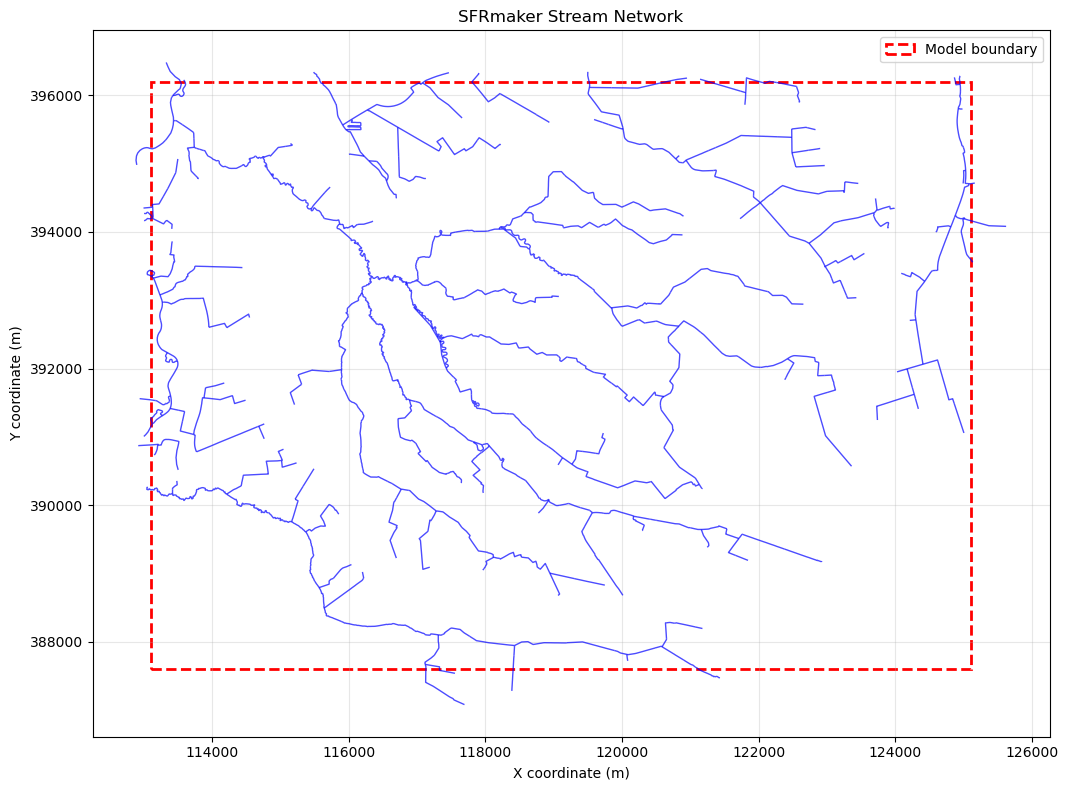

✓ Stream network contains 591 segments


In [55]:
# 3. Visualize the stream network
print("=== Visualizing Stream Network ===")
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the stream network
lines.df.plot(ax=ax, color='blue', linewidth=1, alpha=0.7)

# Add model boundary
from matplotlib.patches import Rectangle
model_rect = Rectangle((Xmin, Ymin), Xmax-Xmin, Ymax-Ymin, 
                      linewidth=2, edgecolor='red', facecolor='none', 
                      linestyle='--', label='Model boundary')
ax.add_patch(model_rect)

ax.set_title('SFRmaker Stream Network')
ax.set_xlabel('X coordinate (m)')
ax.set_ylabel('Y coordinate (m)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Stream network contains {len(lines.df)} segments")

In [56]:
# 4. Analyze network connectivity
print("=== Network Connectivity Analysis ===")
print(f"Segments with downstream connections: {(lines.df['toid'] != 0).sum()}")
print(f"Terminal segments (outlets): {(lines.df['toid'] == 0).sum()}")
print(f"Unique downstream connections: {lines.df['toid'].nunique()}")

# Find headwater segments (no segments flow into them)
all_ids = set(lines.df['id'])
downstream_ids = set(lines.df['toid']) - {0}  # Remove 0 (outlets)
headwater_segments = all_ids - downstream_ids
print(f"Headwater segments: {len(headwater_segments)}")

# Show some statistics
print(f"\nElevation range: {lines.df['elevup'].min():.2f} - {lines.df['elevup'].max():.2f} m")
print(f"Width range: {lines.df['width2'].min():.2f} - {lines.df['width2'].max():.2f} m")

=== Network Connectivity Analysis ===
Segments with downstream connections: 578
Terminal segments (outlets): 13
Unique downstream connections: 487
Headwater segments: 105

Elevation range: -1.63 - 19.80 m
Width range: 0.40 - 999.00 m


### What you can do next with the `lines` object:

**Main Applications:**

1. **Create MODFLOW 6 SFR Package** - The primary goal
2. **Export processed data** - Save cleaned stream network
3. **Quality control** - Validate routing and elevations  
4. **Visualization** - Create maps and plots
5. **Analysis** - Network statistics and connectivity

**Next Steps for MODFLOW 6 Integration:**

In [57]:
# 5. Export processed stream network for future use
print("=== Export Options ===")

# Export as shapefile
output_shp = Pa_GPkg_1ry.replace('.gpkg', '_SFRmaker.shp')
lines.df.to_file(output_shp)
print(f"✓ Exported SFRmaker lines to: {output_shp}")

# Export as GeoPackage  
output_gpkg = Pa_GPkg_1ry.replace('.gpkg', '_SFRmaker.gpkg')
lines.df.to_file(output_gpkg, driver='GPKG')
print(f"✓ Exported SFRmaker lines to: {output_gpkg}")

print(f"✓ Files contain {len(lines.df)} processed stream segments ready for MODFLOW 6")

=== Export Options ===
✓ Exported SFRmaker lines to: C:\OD\WS_Mdl\models\NBr\PrP\SFR\BrabantseDelta\WBD_SW_NW_1ry_SFRmaker.shp
✓ Exported SFRmaker lines to: C:\OD\WS_Mdl\models\NBr\PrP\SFR\BrabantseDelta\WBD_SW_NW_1ry_SFRmaker.gpkg
✓ Files contain 591 processed stream segments ready for MODFLOW 6


# Load imod model and creaste SFR package

## Load PRJ

In [58]:
PRJ_, PRJ_OBS = UIM.o_PRJ_with_OBS(Pa_PRJ)

In [59]:
PRJ, period_data = PRJ_[0], PRJ_[1]

## Load DIS and limit to Mdl Aa

In [60]:
PRJ_regrid = UIM.regrid_PRJ(PRJ, MdlN)

In [61]:
BND = PRJ_regrid['bnd']['ibound']

In [62]:
# Set outer boundaries to -1 (for CHD)

# Get the coordinate indices for boundaries
y_coords = BND.y
x_coords = BND.x
first_y = y_coords.isel(y=0)  # First y coordinate
last_y = y_coords.isel(y=-1)  # Last y coordinate  
first_x = x_coords.isel(x=0)  # First x coordinate
last_x = x_coords.isel(x=-1)  # Last x coordinate

# Set boundary values using .loc indexing
BND.loc[:, first_y, :] = -1  # Top row (all layers, first y, all x)
BND.loc[:, last_y, :] = -1   # Bottom row (all layers, last y, all x)
BND.loc[:, :, first_x] = -1  # Left column (all layers, all y, first x)  
BND.loc[:, :, last_x] = -1   # Right column (all layers, all y, last x)

print("✅ Boundary conditions set successfully!")

✅ Boundary conditions set successfully!


In [63]:
# Set outer boundaries to -1 (for CHD)
BND.loc[:, [BND.y[0], BND.y[-1]], :] = -1  # Top and bottom rows
BND.loc[:, :, [BND.x[0], BND.x[-1]]] = -1  # Left and right columns

print("✅ Boundary conditions set successfully!")


✅ Boundary conditions set successfully!


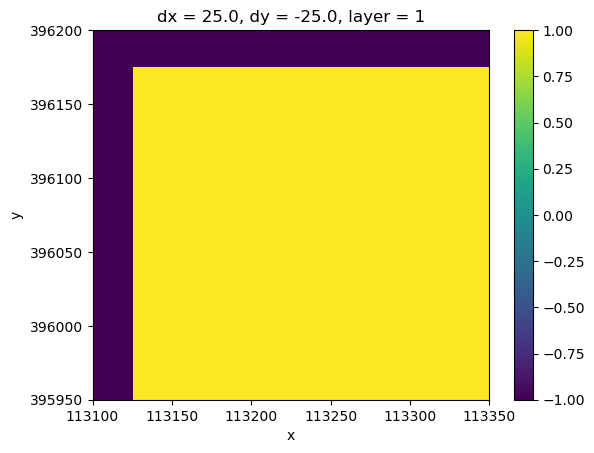

In [64]:
BND.isel(layer=0, x=range(0,10), y=range(0,10)).plot.imshow(cmap='viridis')

## Load MF6 Mdl

In [65]:
times = pd.date_range(SP_date_1st, SP_date_last, freq='D')

Using original PRJ to load MF6 Mdl gives warnings (and it's very slow). Thus, well use the regridded PRJ, which is much faster. It can be further sped up by multi-processing, but this is not implemented yet.

In [66]:
Sim_MF6 = mf6.Modflow6Simulation.from_imod5_data(PRJ_regrid, period_data, times)

NameError: name 'mf6' is not defined

In [ ]:
MF6_Mdl = Sim_MF6['imported_model']

In [ ]:
MF6_Mdl["oc"] = mf6.OutputControl(save_head="last", save_budget="last")
Sim_MF6["ims"] = UIM.mf6_solution_moderate_settings() # Mimic iMOD5's "Moderate" settings

### Load MSW

#### 1st attempt

In [ ]:
MF6_DIS = MF6_Mdl["dis"]  # This gets the OLD 100m grid

In [ ]:
PRJ_MSW = {'cap': PRJ_regrid.copy()['cap'], 'extra': PRJ_regrid.copy()['extra']}

PRJ_regrid['cap'].keys()
for i in PRJ_regrid['cap'].keys():
    print(f" === {i} ===")
    print(PRJ_regrid['cap'][i], "\n")
x_CeCes, y_CeCes = UIM.get_CeCes_from_INI(MdlN)
PRJ['cap']['urban_area'].x.shape[0] / PRJ_regrid['cap']['urban_area'].x.shape[0]
len(x_CeCes)
PRJ['cap']['urban_area'].sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin)).plot(cmap='Spectral')
(PRJ['cap']['urban_area'].sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin)) / PRJ_regrid['cap']['urban_area']).plot(cmap='Spectral')
PRJ_regrid['cap']['urban_area'].plot(cmap='Spectral')

In [ ]:
try:
    MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_MSW, MF6_DIS, times)
    print("🟢 - MetaSwap model created successfully!")
except Exception as e:
    print(f"Error creating MetaSwap model: {e}")
    MSW_Mdl = None

Error creating MetaSwap model: 
Did not find parsable path to existing .ASC file in column 2. Got
values (printing first 10): ['..\\..\\In\\CAP\\P\\NBr1\\P_20100101_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100102_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100103_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100104_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100105_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100106_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100107_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100108_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100109_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100110_NBr1.asc'].


### 2nd attempt

#### Fix mete_grid.inp relative paths
MSW.MetaSwapModel.from_imod5_data is struggling with relative paths, so we'll convert them to full paths. #666 caution, if they're already full paths, this may cause an error.

In [ ]:
# Replace the mete_grid.inp path in the PRJ_MSW_for_MSW dictionary
PRJ['extra']['paths'][2][0] = UIM.mete_grid_Cvt_to_AbsPa(Pa_PRJ, PRJ)

Created corrected mete_grid.inp: C:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\models\NBr\In\CAP\mete_grid\NBr5\temp\mete_grid.inp


#### Finally load MSW Sim

In [ ]:
# Create the MetaSwap model
MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_MSW, MF6_DIS, times)
print("🟢 - MetaSwap model loaded successfully!")

🟢 - MetaSwap model loaded successfully!


## Connect MF6 to MetaSWAP

### Clip models

In [ ]:
Sim_MF6_AoI = Sim_MF6.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

In [ ]:
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [ ]:
MSW_Mdl_AoI = MSW_Mdl.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

In [ ]:
print(f"MF6 Model AoI DIS shape: {MF6_Mdl_AoI['dis'].dataset.sizes}")
print(f"MSW Model AoI grid shape: {MSW_Mdl_AoI['grid'].dataset.sizes}")
print("✅ Both models successfully clipped to Area of Interest with compatible discretization!")

MF6 Model AoI DIS shape: Frozen({'layer': 37, 'y': 344, 'x': 480})
MSW Model AoI grid shape: Frozen({'x': 480, 'y': 344, 'subunit': 2})
✅ Both models successfully clipped to Area of Interest with compatible discretization!


In [ ]:
MF6_Mdl_AoI['dis'].dataset.equals(MF6_Mdl['dis'].dataset)

True

clip_box doesn't clip the packages I clipped beforehand, but it clips non raster-like packages like WEL and removes packages that are not in the AoI.

##### Sense check

In [ ]:
Xmin, Xmax, Ymin, Ymax

(113100.0, 125100.0, 387600.0, 396200.0)

In [ ]:
MF6_Mdl_AoI['dis']['x'].min().values, MF6_Mdl_AoI['dis']['x'].max().values, \
MF6_Mdl_AoI['dis']['y'].min().values, MF6_Mdl_AoI['dis']['y'].max().values

(array(113112.5), array(125087.5), array(387612.5), array(396187.5))

Makes sense as those are cell centers.

### Load models into memory

In [ ]:
for pkg in MF6_Mdl_AoI.values():
    pkg.dataset.load()

for pkg in MSW_Mdl_AoI.values():
    pkg.dataset.load()

### Cleanup

#### MF6 mask

In [ ]:
# Create mask from current regridded model (not the old one)
mask = MF6_Mdl_AoI.domain

In [ ]:
mask

<xarray.DataArray 'idomain' (layer: 37, y: 344, x: 480)> Size: 49MB
array([[[ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        ...,
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1]],

       [[-1, -1, -1, ...,  1,  1,  1],
        [-1, -1, -1, ...,  1,  1,  1],
        [-1, -1, -1, ...,  1,  1,  1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[ 1,  1,  1, ..., -1, -1, -1],
        [ 1,  1,  1, ..., -1, -1, -1],
        [ 1,  1,  1, ..., -1, -1, -1],
        ...,
...
        ...,
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1]],

       [[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        ...,
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1]]], shape=(37, 344, 480))
Coordinates:
    dx       float64 8B 25.0
    dy       float64 8B -25.0
  * layer    (layer) int64 296B 1 2 3 4 5 6 7 8 9 ... 29 30 31 32 33 34 35 36 37
  * y        (y) float64 3kB 3.962e+05 3.962e+05 ... 3.876e+05 3.876e+05
  * x        (x) float64 4kB 1.131e+05 1.131e+05 ... 1.251e+05 1.251e+05

In [ ]:
Sim_MF6_AoI.mask_all_models(mask)
DIS_AoI = MF6_Mdl_AoI["dis"]

#### Check if the packages are the same

In [ ]:
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [ ]:
# Compare the keys of both models
keys_equal = MF6_Mdl.keys() == MF6_Mdl_AoI.keys()
print(f"Are the keys identical? {keys_equal}")
print()

# Get the actual keys for detailed comparison
original_keys = set(MF6_Mdl.keys())
aoi_keys = set(MF6_Mdl_AoI.keys())

print("=== DETAILED KEY COMPARISON ===")
print(f"Original model has {len(original_keys)} packages:")
for key in sorted(original_keys):
    print(f"  - {key}")

print(f"\nAoI model has {len(aoi_keys)} packages:")
for key in sorted(aoi_keys):
    print(f"  - {key}")

# Find differences
missing_in_aoi = original_keys - aoi_keys
extra_in_aoi = aoi_keys - original_keys
common_keys = original_keys & aoi_keys

print(f"\n=== DIFFERENCES ===")
if missing_in_aoi:
    print(f"Packages REMOVED in AoI model ({len(missing_in_aoi)}):")
    for key in sorted(missing_in_aoi):
        print(f"  ❌ {key}")
        # Try to understand why it was removed
        try:
            pkg = MF6_Mdl[key]
            if hasattr(pkg, 'dataset') and hasattr(pkg.dataset, 'sizes'):
                print(f"     Size in original: {dict(pkg.dataset.sizes)}")
        except:
            pass
else:
    print("✅ No packages removed in AoI model")

if extra_in_aoi:
    print(f"\nPackages ADDED in AoI model ({len(extra_in_aoi)}):")
    for key in sorted(extra_in_aoi):
        print(f"  ➕ {key}")
else:
    print("✅ No packages added in AoI model")

print(f"\nCommon packages: {len(common_keys)}/{len(original_keys)} ({100*len(common_keys)/len(original_keys):.1f}%)")

# Show why packages might be missing
if missing_in_aoi:
    print(f"\n=== WHY PACKAGES WERE REMOVED ===")
    print("Packages are typically removed from AoI models when:")
    print("1. They have no data within the clipped boundary")
    print("2. All their stress points/cells fall outside the AoI")
    print("3. The clip_box() method filters out empty packages" \
    "")
    print("\nThis is normal behavior and indicates successful spatial filtering!")

Are the keys identical? False

=== DETAILED KEY COMPARISON ===
Original model has 165 packages:
  - chd_merged
  - dis
  - drn-1
  - drn-2
  - drn-3
  - hfb-1
  - hfb-10
  - hfb-100
  - hfb-101
  - hfb-102
  - hfb-103
  - hfb-104
  - hfb-105
  - hfb-106
  - hfb-107
  - hfb-108
  - hfb-109
  - hfb-11
  - hfb-110
  - hfb-111
  - hfb-112
  - hfb-113
  - hfb-114
  - hfb-115
  - hfb-116
  - hfb-117
  - hfb-118
  - hfb-119
  - hfb-12
  - hfb-120
  - hfb-121
  - hfb-122
  - hfb-123
  - hfb-124
  - hfb-125
  - hfb-126
  - hfb-127
  - hfb-128
  - hfb-129
  - hfb-13
  - hfb-130
  - hfb-131
  - hfb-132
  - hfb-133
  - hfb-134
  - hfb-135
  - hfb-136
  - hfb-137
  - hfb-138
  - hfb-139
  - hfb-14
  - hfb-140
  - hfb-141
  - hfb-142
  - hfb-143
  - hfb-144
  - hfb-145
  - hfb-146
  - hfb-147
  - hfb-148
  - hfb-149
  - hfb-15
  - hfb-150
  - hfb-16
  - hfb-17
  - hfb-18
  - hfb-19
  - hfb-2
  - hfb-20
  - hfb-21
  - hfb-22
  - hfb-23
  - hfb-24
  - hfb-25
  - hfb-26
  - hfb-27
  - hfb-28
  - hfb-29

In [ ]:
# Analyze the data content of common packages
print("=== PACKAGE DATA COMPARISON ===")
print("Comparing spatial dimensions and data ranges for common packages:\n")

for key in sorted(common_keys):
    print(f"📦 {key}:")
    try:
        orig_pkg = MF6_Mdl[key] 
        aoi_pkg = MF6_Mdl_AoI[key]
        
        # Compare dataset sizes
        if hasattr(orig_pkg, 'dataset') and hasattr(aoi_pkg, 'dataset'):
            orig_sizes = dict(orig_pkg.dataset.sizes)
            aoi_sizes = dict(aoi_pkg.dataset.sizes)
            
            print(f"   Original sizes: {orig_sizes}")
            print(f"   AoI sizes:      {aoi_sizes}")
            
            # Calculate reduction ratios
            for dim in ['x', 'y']:
                if dim in orig_sizes and dim in aoi_sizes:
                    reduction = aoi_sizes[dim] / orig_sizes[dim]
                    print(f"   {dim} reduction: {reduction:.3f} ({aoi_sizes[dim]}/{orig_sizes[dim]} cells)")
            
            # Check if data values are the same (for first few values)
            if hasattr(orig_pkg.dataset, 'data_vars') and hasattr(aoi_pkg.dataset, 'data_vars'):
                common_vars = set(orig_pkg.dataset.data_vars) & set(aoi_pkg.dataset.data_vars)
                if common_vars:
                    var = list(common_vars)[0]  # Check first variable
                    orig_data = orig_pkg.dataset[var]
                    aoi_data = aoi_pkg.dataset[var]
                    
                    # Check if AoI data is a subset of original
                    if 'x' in orig_data.dims and 'y' in orig_data.dims:
                        print(f"   Variable '{var}': Data appears to be spatially clipped ✓")
                    else:
                        print(f"   Variable '{var}': Non-spatial data")
        else:
            print("   No dataset attributes to compare")
            
    except Exception as e:
        print(f"   ⚠️  Error comparing {key}: {e}")
    
    print()  # Empty line for readability

=== PACKAGE DATA COMPARISON ===
Comparing spatial dimensions and data ranges for common packages:

📦 chd_merged:
   Original sizes: {'time': 1, 'layer': 19, 'y': 344, 'x': 480}
   AoI sizes:      {'layer': 19, 'y': 344, 'x': 480, 'time': 1}
   x reduction: 1.000 (480/480 cells)
   y reduction: 1.000 (344/344 cells)
   Variable 'observations': Non-spatial data

📦 dis:
   Original sizes: {'layer': 37, 'y': 344, 'x': 480}
   AoI sizes:      {'layer': 37, 'y': 344, 'x': 480}
   x reduction: 1.000 (480/480 cells)
   y reduction: 1.000 (344/344 cells)
   Variable 'top': Data appears to be spatially clipped ✓

📦 drn-1:
   Original sizes: {'layer': 1, 'y': 344, 'x': 480, 'time': 1}
   AoI sizes:      {'layer': 1, 'y': 344, 'x': 480, 'time': 1}
   x reduction: 1.000 (480/480 cells)
   y reduction: 1.000 (344/344 cells)
   Variable 'observations': Non-spatial data

📦 drn-2:
   Original sizes: {'layer': 1, 'y': 344, 'x': 480, 'time': 1}
   AoI sizes:      {'layer': 1, 'y': 344, 'x': 480, 'time': 

In [ ]:
# Compare coordinate bounds to verify clipping worked correctly
print("=== COORDINATE BOUNDS COMPARISON ===")
print(f"Target clipping bounds: X({Xmin:.1f}, {Xmax:.1f}), Y({Ymin:.1f}, {Ymax:.1f})")
print()

# Check DIS package bounds (most reliable for spatial extent)
if 'dis' in common_keys:
    try:
        orig_dis = MF6_Mdl['dis']
        aoi_dis = MF6_Mdl_AoI['dis']
        
        # Original bounds
        orig_x_min, orig_x_max = float(orig_dis.dataset.x.min()), float(orig_dis.dataset.x.max())
        orig_y_min, orig_y_max = float(orig_dis.dataset.y.min()), float(orig_dis.dataset.y.max())
        
        # AoI bounds  
        aoi_x_min, aoi_x_max = float(aoi_dis.dataset.x.min()), float(aoi_dis.dataset.x.max())
        aoi_y_min, aoi_y_max = float(aoi_dis.dataset.y.min()), float(aoi_dis.dataset.y.max())
        
        print("Original model bounds:")
        print(f"   X: {orig_x_min:.1f} to {orig_x_max:.1f} (range: {orig_x_max-orig_x_min:.1f})")
        print(f"   Y: {orig_y_min:.1f} to {orig_y_max:.1f} (range: {orig_y_max-orig_y_min:.1f})")
        
        print("\nAoI model bounds:")
        print(f"   X: {aoi_x_min:.1f} to {aoi_x_max:.1f} (range: {aoi_x_max-aoi_x_min:.1f})")
        print(f"   Y: {aoi_y_min:.1f} to {aoi_y_max:.1f} (range: {aoi_y_max-aoi_y_min:.1f})")
        
        # Verify clipping worked as expected
        x_within_bounds = (aoi_x_min >= Xmin-dx) and (aoi_x_max <= Xmax+dx)
        y_within_bounds = (aoi_y_min >= Ymin-dy) and (aoi_y_max <= Ymax+dy)
        
        print(f"\nClipping verification:")
        print(f"   X bounds within target: {'✓' if x_within_bounds else '✗'}")
        print(f"   Y bounds within target: {'✓' if y_within_bounds else '✗'}")
        
        if x_within_bounds and y_within_bounds:
            print("   🎉 Clipping successful!")
        else:
            print("   ⚠️  Clipping may not have worked as expected")
            
        # Calculate area reduction
        orig_area = (orig_x_max - orig_x_min) * (orig_y_max - orig_y_min)
        aoi_area = (aoi_x_max - aoi_x_min) * (aoi_y_max - aoi_y_min)
        area_ratio = aoi_area / orig_area
        
        print(f"\nArea reduction:")
        print(f"   Original area: {orig_area:,.0f} m²")
        print(f"   AoI area: {aoi_area:,.0f} m²") 
        print(f"   Ratio: {area_ratio:.4f} ({area_ratio*100:.2f}%)")
        
    except Exception as e:
        print(f"Error comparing DIS bounds: {e}")
else:
    print("DIS package not found in common keys - cannot compare bounds")

=== COORDINATE BOUNDS COMPARISON ===
Target clipping bounds: X(113100.0, 125100.0), Y(387600.0, 396200.0)

Original model bounds:
   X: 113112.5 to 125087.5 (range: 11975.0)
   Y: 387612.5 to 396187.5 (range: 8575.0)

AoI model bounds:
   X: 113112.5 to 125087.5 (range: 11975.0)
   Y: 387612.5 to 396187.5 (range: 8575.0)

Clipping verification:
   X bounds within target: ✓
   Y bounds within target: ✓
   🎉 Clipping successful!

Area reduction:
   Original area: 102,685,625 m²
   AoI area: 102,685,625 m²
   Ratio: 1.0000 (100.00%)


In [ ]:
# Print the names of common packages
print("=== COMMON PACKAGES ===")
print(f"These {len(common_keys)} packages are present in both models:")
for i, key in enumerate(sorted(common_keys), 1):
    print(f"{i:2d}. {key}")

=== COMMON PACKAGES ===
These 14 packages are present in both models:
 1. chd_merged
 2. dis
 3. drn-1
 4. drn-2
 5. drn-3
 6. ic
 7. msw-rch
 8. msw-sprinkling
 9. npf
10. oc
11. riv-1riv
12. sto
13. wel-WEL_Br_Wa_T_
14. wel-WEL_Ind_Br_T


In [ ]:
MF6_Mdl_AoI.keys()

KeysView(GroundwaterFlowModel(
    listing_file=None,
    print_input=False,
    print_flows=False,
    save_flows=False,
    newton=False,
    under_relaxation=False,
){
    'dis': StructuredDiscretization,
    'npf': NodePropertyFlow,
    'sto': StorageCoefficient,
    'ic': InitialConditions,
    'wel-WEL_Ind_Br_T': Well,
    'wel-WEL_Br_Wa_T_': Well,
    'msw-sprinkling': LayeredWell,
    'msw-rch': Recharge,
    'drn-1': Drainage,
    'drn-2': Drainage,
    'drn-3': Drainage,
    'riv-1riv': River,
    'chd_merged': ConstantHead,
    'oc': OutputControl,
})

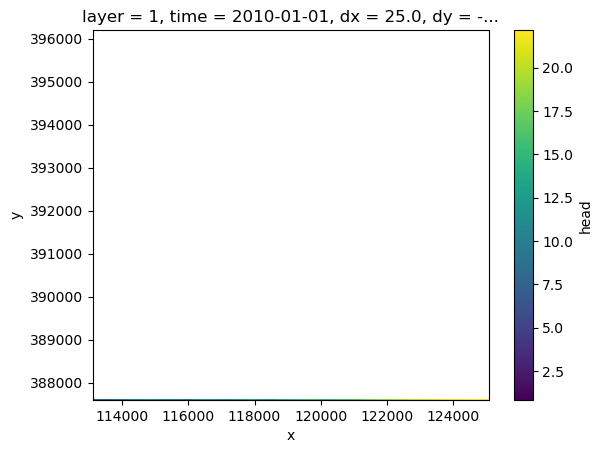

In [ ]:
MF6_Mdl_AoI['chd_merged']['head'].isel(time=0, layer=0).plot.imshow(cmap='viridis')

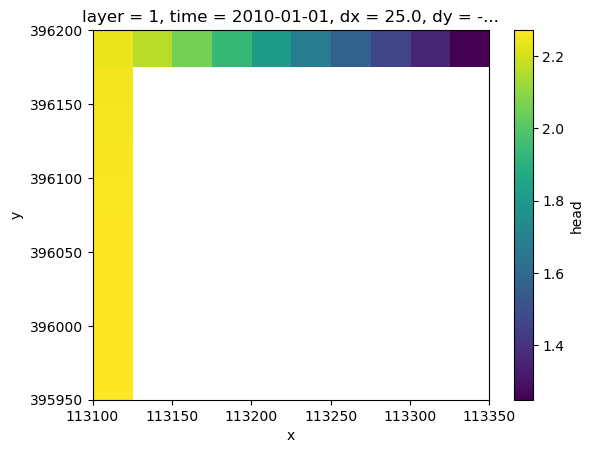

In [ ]:
MF6_Mdl_AoI['chd_merged']['head'].isel(time=0, layer=0, x=range(10), y=range(10)).plot.imshow(cmap='viridis')

Seems like CHD has finally been applied correctly!

This is ok. The only missing package is one of the WEL packages, which has no items in the model area. Also 150 HFB packages/lines have been removed cause none of them intersects the domain.

#### Cleanup MF6

In [ ]:
try:
    for Pkg in [i for i in MF6_Mdl_AoI.keys() if ('riv' in i.lower()) or ('drn' in i.lower())]:
        MF6_Mdl_AoI[Pkg].cleanup(DIS_AoI)
except:
    print('Failed to cleanup packages. Proceeding without cleanup. Fingers crossed!')

#### MSW

In [ ]:
# Cleanup MetaSWAP
MSW_Mdl_AoI["grid"].dataset["rootzone_depth"] = MSW_Mdl_AoI["grid"].dataset["rootzone_depth"].fillna(1.0)

111: Why are we doing this?

## Couple

In [67]:
metamod_coupling = primod.MetaModDriverCoupling(mf6_model="imported_model", mf6_recharge_package="msw-rch", mf6_wel_package="msw-sprinkling")
metamod = primod.MetaMod(MSW_Mdl_AoI, Sim_MF6_AoI, coupling_list=[metamod_coupling])

NameError: name 'primod' is not defined

In [ ]:
os.makedirs(d_Pa['Pa_MdlN'], exist_ok=True) # Create simulation directory if it doesn't exist

In [ ]:
# Use correct paths from d_Pa instead of hardcoded paths
Pa_MF6_DLL = d_Pa['MF6_DLL']
Pa_MSW_DLL = d_Pa['MSW_DLL']
Pa_IMC = d_Pa['coupler_Exe']

print(f"✅ MF6 DLL path: {Pa_MF6_DLL}")
print(f"✅ MSW DLL path: {Pa_MSW_DLL}")
print(f"✅ Coupler exe path: {d_Pa['coupler_Exe']}")

✅ MF6 DLL path: C:/OD/WS_Mdl\software/iMOD5/IMC_2024.4\./modflow6/libmf6.dll
✅ MSW DLL path: C:/OD/WS_Mdl\software/iMOD5/IMC_2024.4\./metaswap/MetaSWAP.dll
✅ Coupler exe path: C:/OD/WS_Mdl\software/iMOD5/IMC_2024.4/imodc.exe


In [ ]:
metamod.write(directory=d_Pa['Pa_MdlN'], modflow6_dll=Pa_MF6_DLL, metaswap_dll=Pa_MSW_DLL, metaswap_dll_dependency=PDN(Pa_MF6_DLL))

# Junkyard

In [ ]:
stop

Columns that seem useful:
1. CODE: as unique ID.
2. NAAM: as name.
3. WS_BH_BOVENSTROOMS: width upstream
4. WS_BH_BENEDENSTROOMS: width downstream
5. WS_HGT_MAAIVELD_BOVS: ground level elevation upstream
6. WS_HGT_MAAIVELD_BENS: ground level elevation downstream
7. WS_HGT_INSTEEK_LINKERZIJDE: left bank elevation
8. WS_HGT_INSTEEK_RECHTERZIJDE: right bank elevation
9. WS_TALUD_LINKS_L: left bank slope
10. WS_TALUD_RECHTS_L: right bank slope
11. WS_BODEMBREEDTE_L: bottom width
12. WS_BH_BOVENSTROOMS_L: width upstream (seems like a duplicate of 2, need to check though)
13. WS_BH_BENEDENSTROOMS_L: width downstream (seems like a duplicate of 3, need to check though)
14. 

Below, we'll match the shapefile attributes to the SFRmaker requirements as per SFRmaker manual ( https://doi-usgs.github.io/sfrmaker/latest/inputs.html):

**Custom hydrography** <br>
Any Polyline shapefile can be supplied in lieu of NHDPlus, but it must have the following columns, as shown in the second example:
1. flowlines_file: path to shapefile<br>-> Pa_GPkg_1ry (object, not column)
2. id_column: unique identifier for each polyline<br>-> CODE
3. routing_column: downstream connection (ID), 0 if none<br>-> DStr *(has been calculated based on algorithm)*<br>
4. width1_column: channel width at start of line, in attr\_length\_units (optional)<br>-> WS_BH_BOVENSTROOMS_L
5. width2_column: channel width at end of line, in attr_length_units (optional)<br>->  WS_BH_BENEDENSTROOMS_L
6. up_elevation_column: streambed elevation at start of line, in attr_height_units<br>-> 
7. dn_elevation_column: streambed elevation at end of line, in attr_height_units<br>-> 
8. name_column: stream name (optional)<br>-> 
9. attr_length_units: channel width units<br>-> m
10. attr_height_units: streambed elevation units<br>-> m


## Limit

In [ ]:
# Limit GDF to model area bounds
print(f"Model area bounds: Xmin: {Xmin:10}, Xmax: {Xmax:10} | Ymin: {Ymin:10}, Ymax: {Ymax:10}\n")
print(f"Original dataset: {bold}{len(GDF):10}{style_reset} features\t| Bounds: {GDF.total_bounds}")

# Create bounding box for clipping
from shapely.geometry import box
model_bbox = box(Xmin, Ymin, Xmax, Ymax)

# Filter GDF to model area using spatial intersection
GDF_clipped = GDF[GDF.geometry.intersects(model_bbox)].copy()

print(f"Filtered dataset: {bold}{len(GDF_clipped):10}{style_reset} features\t| Bounds: {GDF_clipped.total_bounds}")
print(f"Reduction: {bold}{len(GDF)-len(GDF_clipped):,}{style_reset} features removed ({(len(GDF)-len(GDF_clipped))/len(GDF)*100:.1f}%) | ✓ GDF updated to model area extent")
print(f"✓ Network length: {GDF.geometry.length.sum()/1000:.1f} km within model area")

# Update GDF to use the clipped version
GDF = GDF_clipped

In [ ]:
# Plot the filtered hydroobject network within model area
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the filtered GDF
GDF.plot(ax=ax, color='blue', linewidth=0.8, alpha=0.7, label='Hydroobject network')

# Add model boundary rectangle
from matplotlib.patches import Rectangle
model_rect = Rectangle((Xmin, Ymin), Xmax-Xmin, Ymax-Ymin, 
                      linewidth=2, edgecolor='red', facecolor='none', 
                      linestyle='--', label='Model boundary')
ax.add_patch(model_rect)

ax.set_title(f'Hydroobject Network within Model Area ({MdlN})')
ax.set_xlabel('X coordinate (m)')
ax.set_ylabel('Y coordinate (m)')
ax.legend()

# Add statistics text
stats_text = f"""Filtered Network:
• Features: {len(GDF):,}
• Total length: {GDF.geometry.length.sum()/1000:.1f} km
• Model area: {(Xmax-Xmin)/1000:.1f} × {(Ymax-Ymin)/1000:.1f} km"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add grid
ax.grid(True, alpha=0.3)

# Load GPkg. Select correct layer. Limit to Mdl Aa. - Detailed SW network

After this methodology is established, a function should be created that'll take in either a GeoPackage with a specified layer or a shapefile (single layer).<br>
Other Params like the Cols to be used for the SFR network creation, should be provided as well. A .toml file could be a good idea.

## Load

In [ ]:
# First, let's see what layers are available in the GeoPackage
layers = fiona.listlayers(Pa_GPkg)
print("Available layers in GeoPackage:")
for i, L in enumerate(layers):
    print(f"  {i+1}. {L}")

In [ ]:
# Read the hydroobject layer specifically
GDF1 = gpd.read_file(Pa_GPkg, layer=layer)

In [ ]:
print(f"\nHydroobject layer loaded successfully!\nNumber of features: {bold}{len(GDF1)}{style_reset}\nCRS: {bold}{GDF1.crs}{style_reset}\nGeometry types: {GDF1.geometry.geom_type.value_counts()}")
print(*GDF1.columns, sep=' | ')

## Explore

In [ ]:
GDF1.head(3)

In [ ]:
GDF1.describe(include='all')

In [ ]:
#666 columns need to be reviewed later!!!

In [ ]:
GDF1.WS_BH_BOVENSTROOMS.value_counts()

In [ ]:
for i, col in enumerate(GDF1.columns):
    print(f"{i}: {col}")

In [ ]:
GDF1.sort_values('WS_BH_BOVENSTROOMS', inplace=True, ascending=False)

In [ ]:
GDF1[['WS_BH_BOVENSTROOMS', 'WS_BH_BENEDENSTROOMS', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']].head(10)

Columns that seem useful:
1. CODE: as unique ID.
2. NAAM: as name.
3. WS_BH_BOVENSTROOMS: width upstream
4. WS_BH_BENEDENSTROOMS: width downstream
5. WS_HGT_MAAIVELD_BOVS: ground level elevation upstream
6. WS_HGT_MAAIVELD_BENS: ground level elevation downstream
7. WS_HGT_INSTEEK_LINKERZIJDE: left bank elevation
8. WS_HGT_INSTEEK_RECHTERZIJDE: right bank elevation
9. WS_TALUD_LINKS_L: left bank slope
10. WS_TALUD_RECHTS_L: right bank slope
11. WS_BODEMBREEDTE_L: bottom width
12. WS_BH_BOVENSTROOMS_L: width upstream (seems like a duplicate of 2, need to check though)
13. WS_BH_BENEDENSTROOMS_L: width downstream (seems like a duplicate of 3, need to check though)
14. 

In [ ]:
print('Plot of line geometry in the whole area.')
GDF1.plot(figsize=(10, 10), color='blue', edgecolor='black')

## Limit

In [ ]:
# Limit GDF to model area bounds
print(f"Model area bounds: Xmin: {Xmin:10}, Xmax: {Xmax:10} | Ymin: {Ymin:10}, Ymax: {Ymax:10}\n")
print(f"Original dataset: {bold}{len(GDF1):10}{style_reset} features\t| Bounds: {GDF1.total_bounds}")

# Create bounding box for clipping
from shapely.geometry import box
model_bbox = box(Xmin, Ymin, Xmax, Ymax)

# Filter GDF to model area using spatial intersection
GDF1_clipped = GDF1[GDF1.geometry.intersects(model_bbox)].copy()

print(f"Filtered dataset: {bold}{len(GDF1_clipped):10}{style_reset} features\t| Bounds: {GDF1_clipped.total_bounds}")
print(f"Reduction: {bold}{len(GDF1)-len(GDF1_clipped):,}{style_reset} features removed ({(len(GDF1)-len(GDF1_clipped))/len(GDF1)*100:.1f}%) | ✓ GDF updated to model area extent")
print(f"✓ Network length: {GDF1.geometry.length.sum()/1000:.1f} km within model area")

# Update GDF to use the clipped version
GDF1 = GDF1_clipped

In [ ]:
# Plot the filtered hydroobject network within model area
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the filtered GDF
GDF1.plot(ax=ax, color='blue', linewidth=0.8, alpha=0.7, label='Hydroobject network')

# Add model boundary rectangle
from matplotlib.patches import Rectangle
model_rect = Rectangle((Xmin, Ymin), Xmax-Xmin, Ymax-Ymin, 
                      linewidth=2, edgecolor='red', facecolor='none', 
                      linestyle='--', label='Model boundary')
ax.add_patch(model_rect)

ax.set_title(f'Hydroobject Network within Model Area ({MdlN})')
ax.set_xlabel('X coordinate (m)')
ax.set_ylabel('Y coordinate (m)')
ax.legend()

# Add statistics text
stats_text = f"""Filtered Network:
• Features: {len(GDF1):,}
• Total length: {GDF1.geometry.length.sum()/1000:.1f} km
• Model area: {(Xmax-Xmin)/1000:.1f} × {(Ymax-Ymin)/1000:.1f} km"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add grid
ax.grid(True, alpha=0.3)